# Vanilla GAN

DCGAN uses the convolutional layers for both discriminator and generator. By doing so, it is said to generate sharper images. In this notebook, we will see whether this actually happens for MNIST with our settings of the hyper-parameter.

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


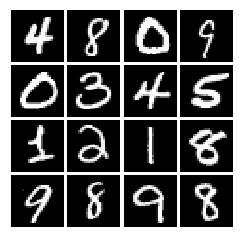

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [9]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, (tf.shape(x)[0], 28, 28, 1), name="reshape_3d")
        conv_1 = tf.layers.conv2d(x, filters=32, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_1")
        pool_1 = tf.layers.max_pooling2d(conv_1, pool_size=(2, 2), strides=2, name="pool_1")
        conv_2 = tf.layers.conv2d(pool_1, filters=64, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_2")
        pool_2 = tf.layers.max_pooling2d(conv_2, pool_size=(2, 2), strides=2, name="pool_2")
        fc_1 = tf.layers.conv2d(pool_2, filters=1024, kernel_size=(4, 4), name="fc_1", activation=tf.nn.leaky_relu)
        logits = tf.layers.conv2d(fc_1, filters=1, kernel_size=(1, 1), name="logits")
        return tf.reshape(logits, (-1, 1))

#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). 

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [5]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.layers.dense(bn1, 7 * 7 * 128, tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2)
        image_tensor = tf.reshape(bn2, (tf.shape(z)[0], 7, 7, 128))
        conv_T_1 = tf.layers.conv2d_transpose(image_tensor, filters=64, kernel_size=(4, 4), 
                                              strides=(2, 2), padding="same", activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(conv_T_1)
        conv_T_2 = tf.layers.conv2d_transpose(bn3, filters=1, kernel_size=(4, 4), strides=(2, 2), 
                                               padding="same", activation=tf.nn.tanh)
        img = tf.reshape(conv_T_2, (-1,784))
    return img

# GAN Loss

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

In [6]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    ones_labels_d = tf.ones_like(logits_real) 
    zeros_labels_d = tf.zeros_like(logits_fake)
    
    ones_labels_g = tf.ones_like(logits_fake)
    
    real_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones_labels_d)
    fake_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros_labels_d)
    D_loss = tf.reduce_mean(real_data_predictions) + tf.reduce_mean(fake_data_predictions)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones_labels_g))
    return D_loss, G_loss

# Optimizing our loss

In [7]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

# Training a GAN!

In [10]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [11]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch_x})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

#### Train DCGAN! 

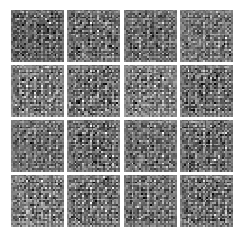


Iter: 0, D: 1.352, G:0.6472
Iter: 50, D: 0.758, G:1.543
Iter: 100, D: 0.2828, G:3.057
Iter: 150, D: 0.6587, G:0.4881
Iter: 200, D: 1.986, G:0.9585


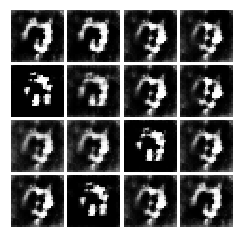


Iter: 250, D: 1.238, G:2.024
Iter: 300, D: 1.071, G:1.945
Iter: 350, D: 1.189, G:2.635
Iter: 400, D: 1.412, G:1.309
Iter: 450, D: 0.7123, G:1.421


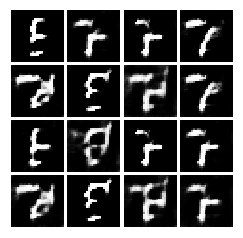


Iter: 500, D: 0.574, G:1.981
Iter: 550, D: 0.6516, G:1.143
Iter: 600, D: 0.5589, G:2.471
Iter: 650, D: 0.584, G:2.391
Iter: 700, D: 0.3718, G:2.682


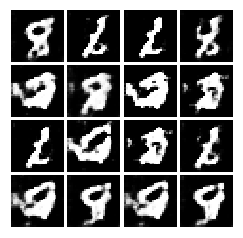


Iter: 750, D: 0.5809, G:3.649
Iter: 800, D: 1.847, G:0.2433
Iter: 850, D: 0.3091, G:3.312
Iter: 900, D: 0.583, G:2.327
Iter: 950, D: 0.8628, G:2.815


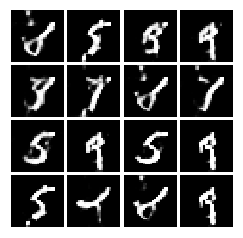


Iter: 1000, D: 0.3722, G:3.118
Iter: 1050, D: 0.8274, G:3.431
Iter: 1100, D: 0.731, G:1.484
Iter: 1150, D: 0.6193, G:2.99
Iter: 1200, D: 0.8866, G:5.102


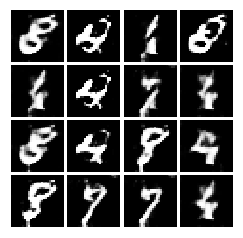


Iter: 1250, D: 0.5725, G:2.328
Iter: 1300, D: 0.32, G:2.483
Iter: 1350, D: 0.3239, G:2.428
Iter: 1400, D: 0.4959, G:2.844
Iter: 1450, D: 0.7871, G:2.998


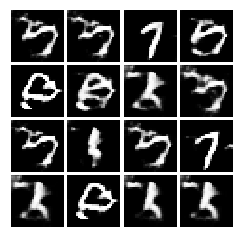


Iter: 1500, D: 0.5551, G:2.428
Iter: 1550, D: 0.7643, G:2.736
Iter: 1600, D: 0.6414, G:2.175
Iter: 1650, D: 0.4737, G:4.589
Iter: 1700, D: 0.4339, G:2.959


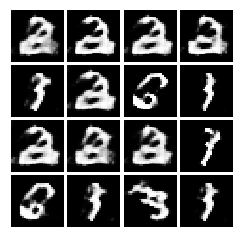


Iter: 1750, D: 0.5879, G:3.256
Iter: 1800, D: 0.5551, G:2.293
Iter: 1850, D: 0.657, G:2.32
Iter: 1900, D: 0.2718, G:3.328
Iter: 1950, D: 0.4675, G:2.574


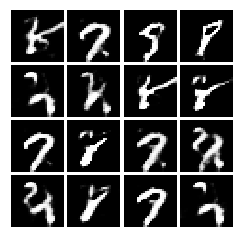


Iter: 2000, D: 0.3173, G:4.128
Iter: 2050, D: 0.5848, G:2.852
Iter: 2100, D: 0.814, G:4.401
Iter: 2150, D: 0.4459, G:4.487
Iter: 2200, D: 0.6496, G:3.922


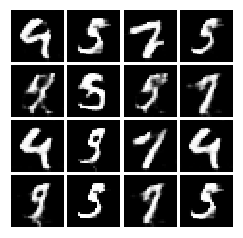


Iter: 2250, D: 0.8167, G:2.719
Iter: 2300, D: 0.4078, G:3.571
Iter: 2350, D: 0.4159, G:3.388
Iter: 2400, D: 0.4615, G:2.58
Iter: 2450, D: 0.5747, G:2.892


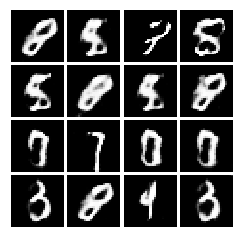


Iter: 2500, D: 0.6665, G:2.992
Iter: 2550, D: 0.3962, G:5.058
Iter: 2600, D: 0.5784, G:3.479
Iter: 2650, D: 0.4478, G:2.97
Iter: 2700, D: 0.548, G:1.953


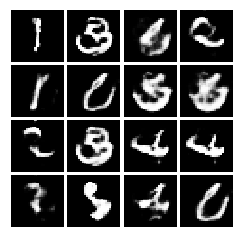


Iter: 2750, D: 0.4911, G:4.711
Iter: 2800, D: 0.6225, G:2.286
Iter: 2850, D: 0.5848, G:1.417
Iter: 2900, D: 0.463, G:2.742
Iter: 2950, D: 0.3262, G:2.337


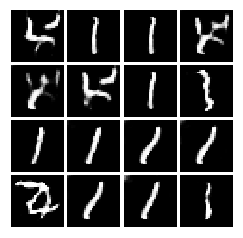


Iter: 3000, D: 0.363, G:3.142
Iter: 3050, D: 0.5376, G:2.41
Iter: 3100, D: 0.5015, G:2.285
Iter: 3150, D: 0.4368, G:3.131
Iter: 3200, D: 0.4716, G:2.163


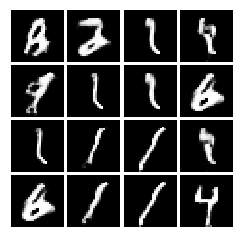


Iter: 3250, D: 0.4622, G:2.824
Iter: 3300, D: 0.4564, G:3.18
Iter: 3350, D: 0.4894, G:2.301
Iter: 3400, D: 0.4697, G:2.474
Iter: 3450, D: 0.5237, G:2.651


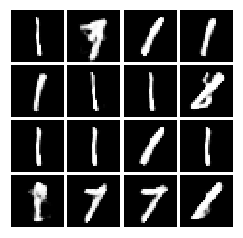


Iter: 3500, D: 0.4369, G:2.642
Iter: 3550, D: 0.5163, G:2.236
Iter: 3600, D: 0.2972, G:2.667
Iter: 3650, D: 0.4081, G:2.998
Iter: 3700, D: 0.4974, G:1.413


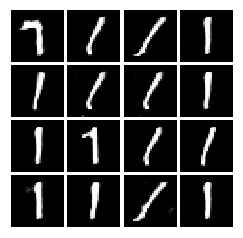


Iter: 3750, D: 0.5017, G:2.748
Iter: 3800, D: 0.4752, G:2.991
Iter: 3850, D: 0.4095, G:2.847
Iter: 3900, D: 0.5892, G:2.951
Iter: 3950, D: 0.4913, G:2.699


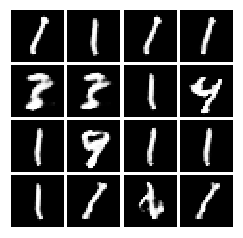


Iter: 4000, D: 0.3525, G:2.448
Iter: 4050, D: 0.3523, G:2.539
Iter: 4100, D: 0.3869, G:2.476
Iter: 4150, D: 0.3913, G:2.58
Iter: 4200, D: 0.5164, G:2.757


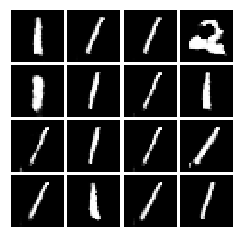


Iter: 4250, D: 0.6986, G:3.159
Final images


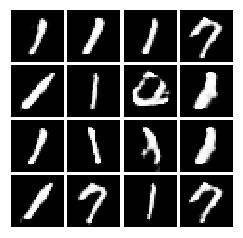

In [12]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

## Conclusion

We clearly see that images are sharper here. There is less jittering compare to Vanila GAN. However, we see that most of the images are $1$. Is it a mode collapse? Can Least Square loss helps here? Can we use one-sided label smoothening to alleviate these problems. These problems will be the focus of upcoming notebooks.  